<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [ ]:
# Download the Dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

In [3]:
import requests

def download_file(url, filename):
    """
    This function downloads a file from the given URL and saves it with the given filename.
    It handles HTTP errors and writes the content of the response to a file.
    """
    # Send a HTTP request to the specified URL
    response = requests.get(url)

    try:
        # If the HTTP request returned an unsuccessful status code, raise an HTTPError
        response.raise_for_status()
        
        # Write the content of the response to a file
        with open(filename, "wb") as file:
            file.write(response.content)
            
    except requests.exceptions.HTTPError as http_error:
        # If an HTTPError occurs, print the error message
        print(f"An HTTP error occurred: {http_error}")

# The URL of the file to download
file_url = "https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv"

# The name to save the file as
file_name = "Sunspots.csv"

# Call the function to download the file
download_file(file_url, file_name)

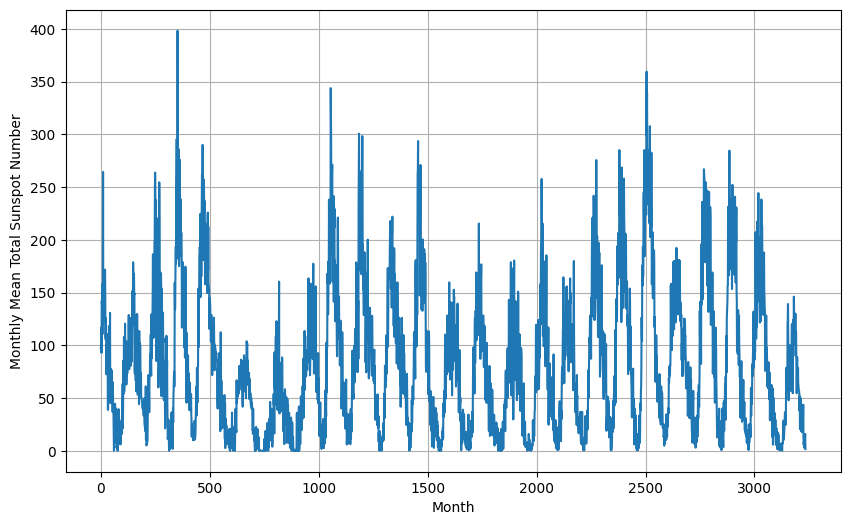

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [5]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.

In [31]:
# Parameters
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

<details>
    <summary><span style="color:green"><b>Click for additional information</b></span></summary>

Here's a breakdown of the parameters:

- `window_size = 30`: This is the size of the window of data the model will look at at one time. In this case, the model will look at 30 data points at a time.

- `batch_size = 32`: This is the number of data samples the model will process before updating its internal parameters. In this case, the model will process 32 samples, then update its parameters, then process the next 32 samples, and so on.

- `shuffle_buffer_size = 1000`: This is the number of samples from which the model will randomly select to create each batch. A larger shuffle buffer size increases randomness and helps to make the model's training more effective.

The `windowed_dataset` function is then called with these parameters and the training data (`x_train`). This function will create a dataset of windowed data samples for the model to train on. Each sample will contain 30 consecutive data points from `x_train`, and the samples will be grouped into batches of 32.

In other words, the model will be trained on batches of 32 samples, each sample containing 30 consecutive data points, and the order of the samples will be randomized to improve training effectiveness.

  </summary>
</details>


## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [9]:
# Build the Model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=[window_size, 1]),
        tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=3,
            strides=1,
            activation="relu",
            padding="causal",
        ),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400),
    ]
)

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [10]:
# Get initial weights
init_weights = model.get_weights()

In [11]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=2)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 196.8442 - learning_rate: 1.0000e-08
Epoch 2/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - loss: 62.1137

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 84.3557 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 79.6944 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 76.8016 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 73.5447 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 71.6937 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 69.2029 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 69.2292 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 66.7733 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 64.4387 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 62.9417 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/st

(1e-08, 0.001, 0.0, 100.0)

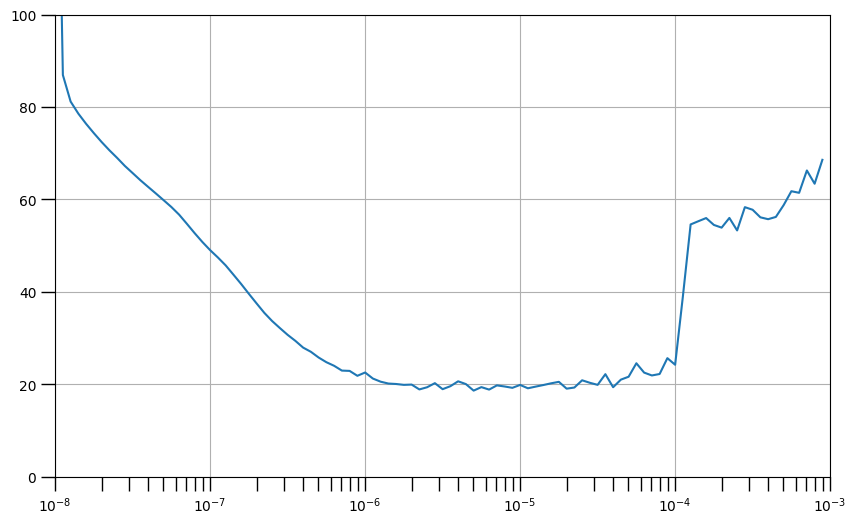

In [12]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [13]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [14]:
# Set the learning rate
learning_rate = 4e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [15]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 71.7908 - mae: 72.2960
Epoch 2/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 43.1574 - mae: 43.6574

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 50.7088 - mae: 51.2135
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 40.0691 - mae: 40.5691
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 24.5858 - mae: 25.0825
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 22.3560 - mae: 22.8546
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 20.6250 - mae: 21.1207
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 23.2904 - mae: 23.7861
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 19.6755 - mae: 20.1695
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 20.3977 - mae: 20.8933
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 19.3767 - mae: 19.8728
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 19.3014 - mae: 19.7970
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 18.9429 - mae: 19.4358
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 21.3748 - mae: 21.8716
Epoch 14/100

You can visualize the training and see if the loss and MAE are still trending down.

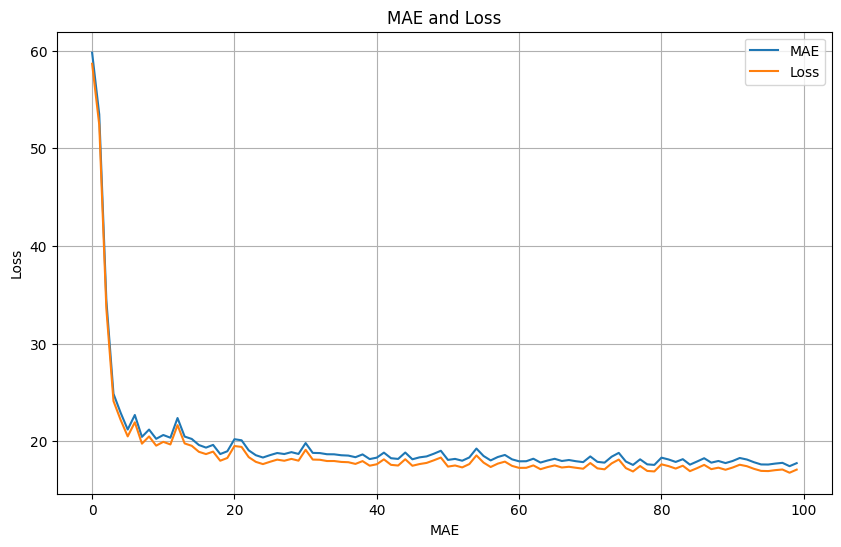

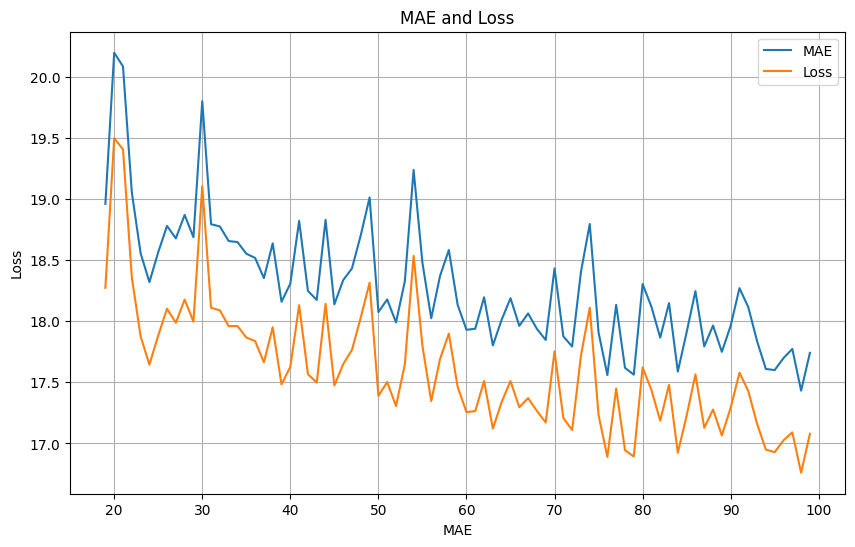

In [16]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [17]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


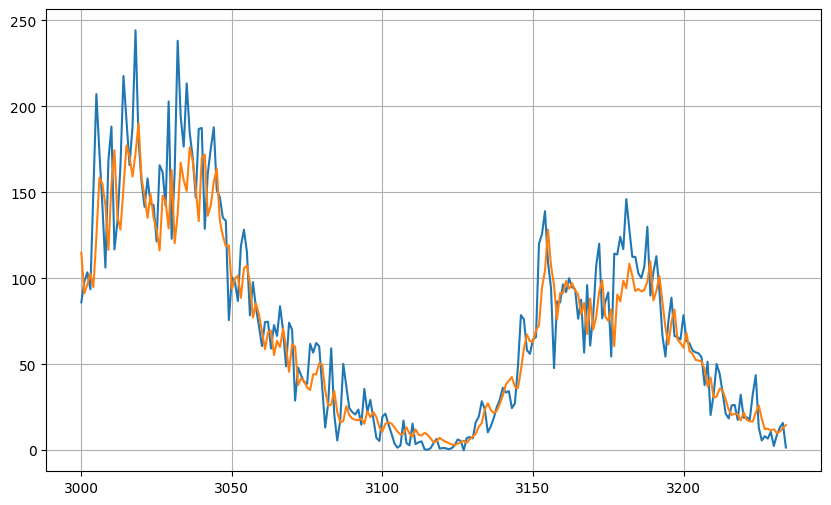

In [18]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [19]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

15.147705


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!

## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.

In [20]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 16.8535 - mae: 17.3468
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 16.2389 - mae: 16.7274
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 16.5675 - mae: 17.0576
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 16.1476 - mae: 16.6381
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 16.2554 - mae: 16.7459
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 16.2209 - mae: 16.7125
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 16.6829 - mae: 17.1743
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 15.6176 - mae: 16.1082
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 16.0979 - mae: 16.5876
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 16.5679 - mae: 17.0593


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [32]:
# Parameters
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=300,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 16.4395 - mae: 16.9495
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 16.1969 - mae: 16.7022
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 16.6121 - mae: 17.1184
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 16.7475 - mae: 17.2561
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 16.2358 - mae: 16.7428
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 16.5422 - mae: 17.0517
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 16.4185 - mae: 16.9160
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 16.2411 - mae: 16.7475
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 16.8312 - mae: 17.3400
Epoch 10/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 16.2121 - mae: 16.7188
Epoch 11/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 16.2410 - mae: 16.7475
Epoch 12/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 16.1550 - mae: 16.6562
Epoch 13/40
30/30 ━━━━━━

<details>
<summary><span style="color:green">Click for additional information</span></summary>

The `ExponentialDecay` function in TensorFlow is used to gradually reduce the learning rate over time. This is known as learning rate decay or learning rate scheduling.

Here's a breakdown of the parameters:

- `initial_learning_rate=1e-7`: This is the starting learning rate.
- `decay_steps=400`: This is the number of steps (batches of data) after which the learning rate decay is applied.
- `decay_rate=0.96`: This is the rate at which the learning rate is reduced. In this case, the learning rate is multiplied by 0.96 every 400 steps.
- `staircase=True`: If `True`, the learning rate is reduced in a discrete, staircase-like fashion (i.e., at every integer multiple of `decay_steps`). If `False`, the learning rate changes after every step in a smooth, continuous fashion.

The reason for using a learning rate schedule like `ExponentialDecay` instead of a static learning rate is that it can help the model converge more quickly and achieve better performance. 

At the start of training, when the model's weights are random, larger learning rate steps can help the model to quickly escape from poor areas in the weight space. However, as training progresses and the model gets closer to the optimal weights, smaller learning rate steps can help the model to fine-tune its weights and converge to a better solution.

By starting with a larger learning rate and reducing it over time, learning rate decay combines the benefits of both large and small learning rates.

In machine learning, a "step" usually refers to one iteration of the training process, where the model looks at a batch of data, makes predictions, calculates the error, and updates its weights.

The `decay_steps` parameter in the `ExponentialDecay` function is telling the model how often to reduce the learning rate. 

If `decay_steps=400`, this means the learning rate will be reduced every 400 steps. 

So, if you're training the model and each batch of data contains 32 samples (as defined by `batch_size=32`), then the learning rate will be reduced every 12,800 samples (because 400 steps * 32 samples/step = 12,800 samples). 

In other words, every 12,800 samples, the learning rate is multiplied by the `decay_rate` (0.96 in your code), making the learning rate a bit smaller and the model's learning a bit slower.

The `staircase` parameter in the `ExponentialDecay` function determines how the learning rate decreases over time.

If `staircase=True`, the learning rate will decrease in a step-like fashion, similar to how you'd descend a staircase. This means the learning rate stays the same for a certain number of steps (as defined by `decay_steps`), then suddenly drops, stays the same for another number of steps, then drops again, and so on. 

In your code, `decay_steps=400`, so the learning rate will stay the same for 400 steps, then drop, stay the same for another 400 steps, then drop again, and so on.

If `staircase=False`, the learning rate decreases a little bit after each step, creating a smooth, continuous decline over time, like sliding down a ramp.

The choice between a staircase-like decay and a continuous decay often depends on the specific problem and how quickly you want the learning rate to decrease. Both methods have their uses in different situations.
</details>

Now see the results by geting predicitons and computing the metrics.

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step


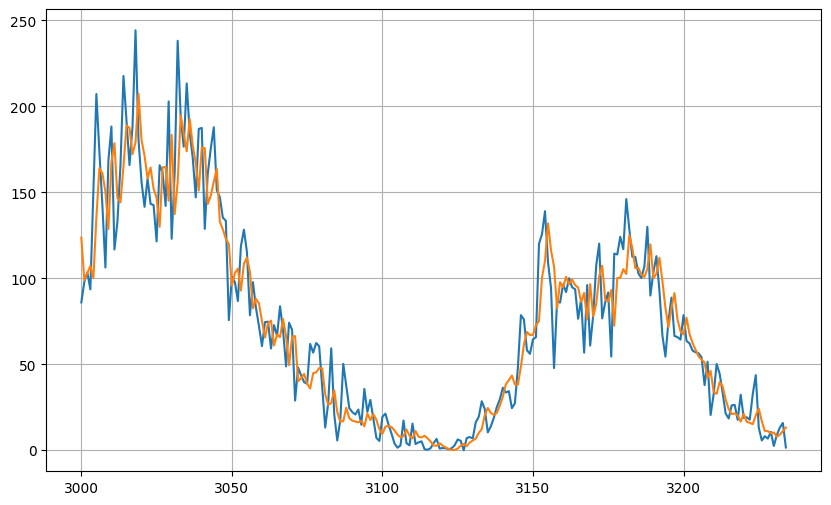

In [33]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [34]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.287753